# CitiBike 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [25]:
files = glob.glob('data/*.csv')
df = pd.DataFrame()
columns = ['tripduration', 'starttime', 'start station id', 'end station id',
           'bikeid', 'usertype', 'birth year', 'gender']
for file in files:
    df_tmp = pd.read_csv(file, usecols=columns , nrows=1e4)
    df = pd.concat([df, df_tmp])

In [26]:
df.columns

Index(['tripduration', 'starttime', 'start station id', 'end station id',
       'bikeid', 'usertype', 'birth year', 'gender'],
      dtype='object')

In [27]:
df.head()

,tripduration,starttime,start station id,end station id,bikeid,usertype,birth year,gender
0,681,2018-08-01 00:00:07.3210,3162.0,3383.0,27770,Subscriber,1986,1
1,625,2018-08-01 00:00:19.7480,3260.0,2012.0,25938,Subscriber,1969,1
2,1319,2018-08-01 00:00:21.1750,403.0,285.0,28679,Subscriber,1970,1
3,220,2018-08-01 00:00:26.4700,3637.0,399.0,28075,Subscriber,1982,1
4,398,2018-08-01 00:00:30.2910,3662.0,3517.0,25002,Subscriber,1987,1


In [28]:
df.describe()

,tripduration,start station id,end station id,bikeid,birth year,gender
count,1.200000e+05,119987.000000,119987.000000,120000.000000,120000.000000,120000.000000
mean,9.668182e+02,774.090685,1381.133881,26631.007108,1978.311542,1.165875
std,2.080159e+04,1242.836916,1401.008053,6191.597512,12.156792,0.522044
min,6.100000e+01,72.000000,72.000000,14529.000000,1885.000000,0.000000
25%,3.580000e+02,79.000000,345.000000,20373.000000,1969.000000,1.000000
50%,5.980000e+02,127.000000,477.000000,28456.000000,1981.000000,1.000000
75%,1.027000e+03,480.000000,3175.000000,31898.000000,1988.000000,1.000000
max,5.891578e+06,3715.000000,3715.000000,35688.000000,2002.000000,2.000000


In [29]:
df.shape

(120000, 8)

## Raised Questions
* In order to predict future number of trips, What factors effect ?
* Does the trip duration has any correlation with other variables ?
* Does 

In [30]:
df.starttime = pd.to_datetime(df.starttime)

## Univariate Exploration

In [31]:
base_color = sns.color_palette()[0]

(0, 5000)

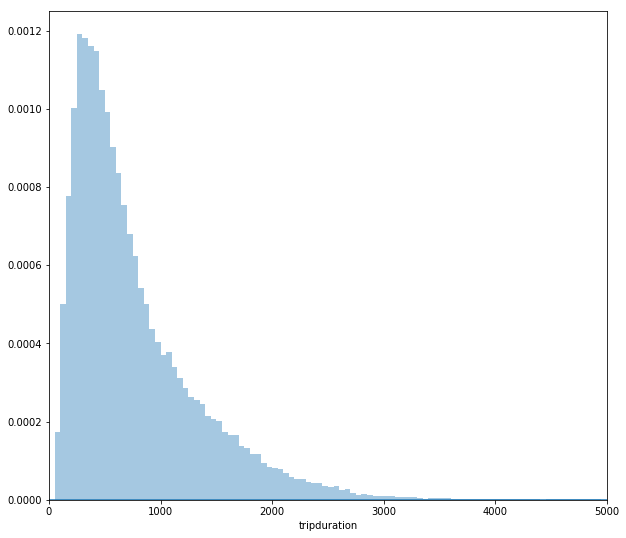

In [103]:
plt.figure(figsize=(10,9))
bins = np.arange(0, 5000, 50)
sns.distplot(df.tripduration, bins=bins, color=base_color)
plt.xlim(0,5000)

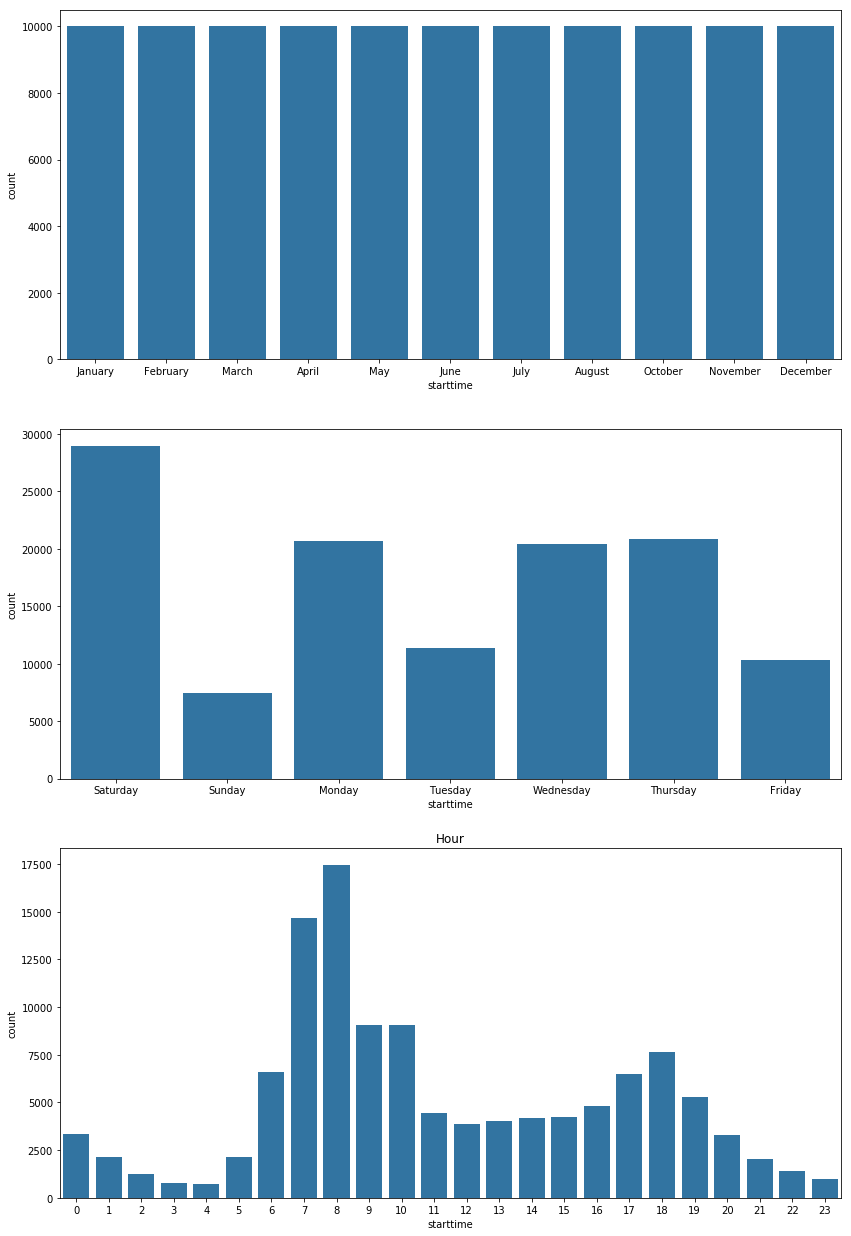

In [120]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14,12))
fig.subplots_adjust(top=1.5)

order = {'month':['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'October', 'November', 'December'],
         'week day': ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']}

sns.countplot(df.starttime.dt.month_name(), order=order['month'],color=base_color, ax=ax[0]);
plt.title('month')

sns.countplot(df.starttime.dt.day_name(), order=order['week day'], color=base_color, ax=ax[1]);
plt.title('Week days')

sns.countplot(df.starttime.dt.hour, color=base_color, ax=ax[2]);
plt.title('Hour')
plt.show()

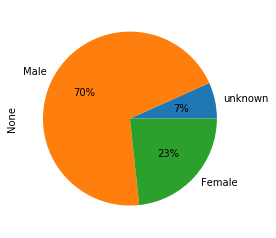

In [139]:
label = ['unknown', 'Male', 'Female']
df.groupby('gender').size().plot(kind='pie',labels=label,  autopct='%1.0f%%');

Text(0, 0.5, '')

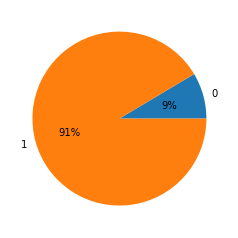

In [132]:
df.groupby('usertype').size().plot(kind='pie', labels=gender_grouped.index, autopct='%1.0f%%');
plt.ylabel('')

(1940, 2007)

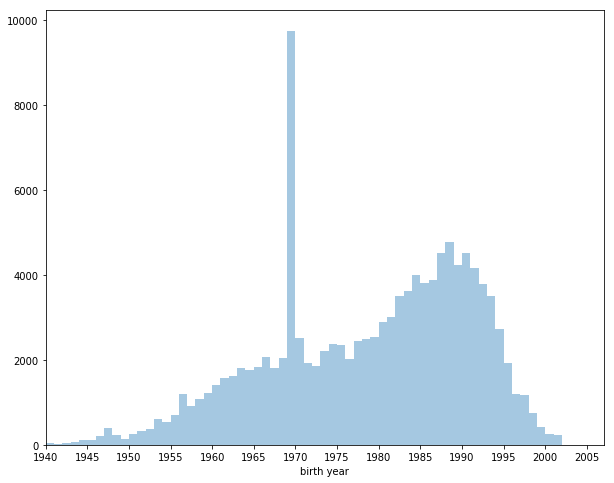

In [37]:
plt.figure(figsize=(10,8))
base_color = sns.color_palette()[0]
max_birth = df['birth year'].max()
bins = np.arange(1940, max_birth + 1, 1)
labels=np.arange(1940, max_birth + 5, 5)
sns.distplot(df['birth year'],bins=bins,kde=False, color=base_color);
plt.xticks(labels);
plt.xlim(1940, max_birth + 5)

The shape is sekead to left, with one big spike in year 1969.
After futhur investigaion, I found many customers sigend with 1969 birth year. This might be cuased by someone filled Null values with this specfic year.<br>
This quality issue must be solved to pr********

## Bivirate exploration

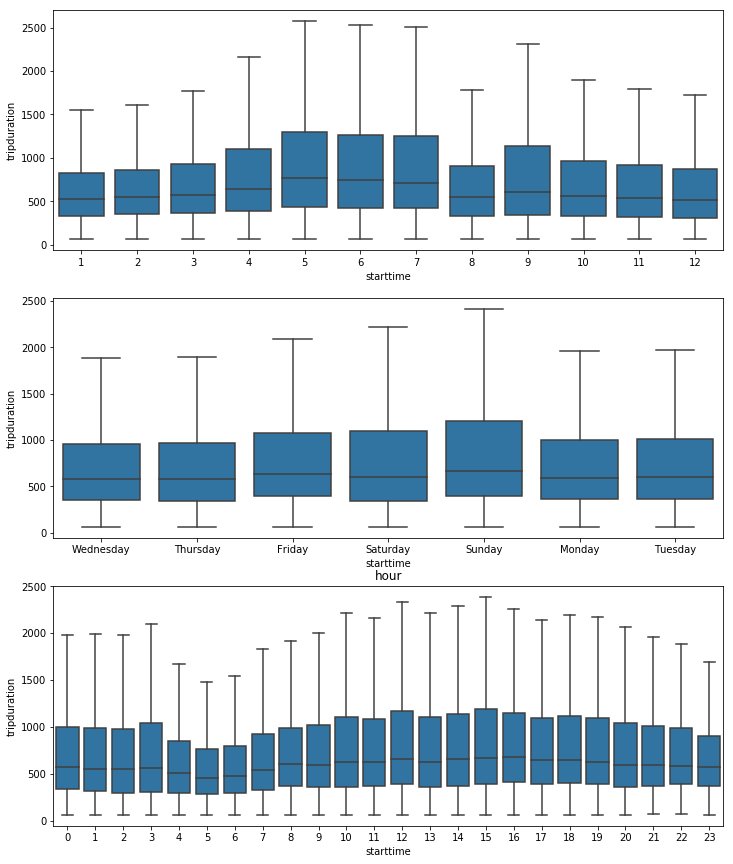

In [102]:
fig, ax = plt.subplots(nrows=3, figsize=(12,15))

plt.title('month')
sns.boxplot(df.starttime.dt.month, df.tripduration, showfliers=False, color=base_color, ax=ax[0])

plt.title('week day')
sns.boxplot(df.starttime.dt.day_name(), df.tripduration, showfliers=False, color=base_color, ax=ax[1])

plt.title('hour')
sns.boxplot(df.starttime.dt.hour, df.tripduration, showfliers=False, color=base_color, ax=ax[2])

plt.show()

/home/srap/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


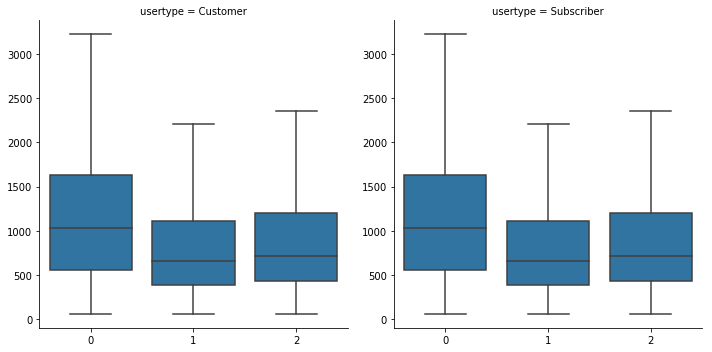

In [141]:
gender_df = df.groupby(['start station id','end station id','gender','usertype']). tripduration.mean().reset_index()
g = sns.FacetGrid(gender_df, col='usertype', sharey=False, height=5)
g.map(sns.boxplot, x='gender', y='tripduration', showfliers=False, data=gender_df)
plt.show()